In [105]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph langchain langchain-community

In [106]:
import os
GEMINI_API_KEY = os.environ.get("GOOGLE_API_KEY")

## Schema

When we define a Langgraph `StateGraph`, we use a State Schema.

The state schema represents the stucture and types of data that our graph will use.

All nodes are expected to communicate using that schema.

### TypedDict

In [107]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: int

In [108]:
choco_bars: TypedDictState = TypedDictState(company="Choco", bar="M&Ms")
print(choco_bars["bar"])
print(choco_bars["company"])

M&Ms
Choco


In [109]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

In [110]:
override_mood: TypedDictState = TypedDictState(name="Choco", mood="mad")
override_mood["mood"]
print(override_mood)

{'name': 'Choco', 'mood': 'mad'}


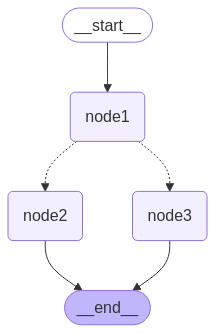

In [111]:
import random
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

def node_1(state: TypedDictState):
    print("Node 1")
    return {"name": state['name'] + " is ..."}

def node_2(state: TypedDictState):
    print("Node 2")
    return {"mood": "mad"}

def node_3(state: TypedDictState):
    print("Node 3")
    return {"mood": "happy"}

def decide_mood(state: TypedDictState) -> Literal["node2", "node3"]:
    if random.random() < 0.5:
        return "node2"
    return "node3"


builder: StateGraph = StateGraph(TypedDictState)
builder.add_node("node1", node_1)
builder.add_node("node2", node_2)
builder.add_node("node3", node_3)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_mood)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [112]:
graph.invoke({"name": "Choco"})

Node 1
Node 2


{'name': 'Choco is ...', 'mood': 'mad'}

### Dataclass

In [113]:
from dataclasses import dataclass

@dataclass
class DataClassState:
    name: str
    mood: Literal["happy", "sad"]
    
no_name: DataClassState = DataClassState(name="Choco", mood=random.choice(["happy", "sad"]))
no_name

DataClassState(name='Choco', mood='sad')

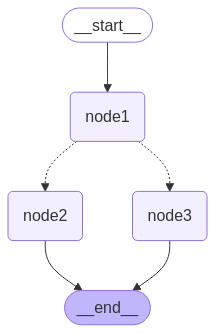

In [114]:
def node_1(state: DataClassState) -> dict:
    print("Node 1")
    return {"name": state.name + " is ..."}

def node_2(state: DataClassState) -> dict:
    print("Node 2")
    return {"mood": "mad"}

def node_3(state: DataClassState) -> dict:
    print("Node 3")
    return {"mood": "happy"}

def decide_mood(state: DataClassState) -> Literal["node2", "node3"]:
    if random.random() < 0.5:
        return "node2"
    return "node3"

builder: StateGraph = StateGraph(DataClassState)
builder.add_node("node1", node_1)
builder.add_node("node2", node_2)
builder.add_node("node3", node_3)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_mood)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [115]:
graph.invoke({"name": "Choco", "mood": "happy"})

Node 1
Node 2


{'name': 'Choco is ...', 'mood': 'mad'}

In [116]:
graph.invoke({"name": "Choco", "mood": "still not enforced"})

Node 1
Node 3


{'name': 'Choco is ...', 'mood': 'happy'}

In [117]:
graph.invoke({"name": "Choco", "mood": "still not enforced", "random": "value"})

Node 1
Node 3


{'name': 'Choco is ...', 'mood': 'happy'}

### Pydantic

In [118]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]

    @field_validator("mood")
    @classmethod
    def check_mood(cls, value):
        if value not in ["happy", "sad"]:
            raise ValueError("Mood must be either 'happy' or 'sad'")
        return value
    
try:
    state = PydanticState(name="Choco", mood="mad")
except ValidationError as e:    
    print("Validation Error:", e)
    
    

Validation Error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/literal_error


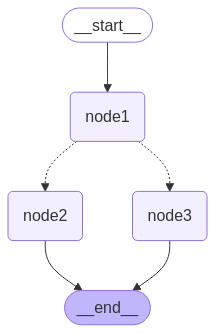

In [119]:
def node_1(state: PydanticState) -> dict:
    print("Node 1")
    return {"name": state.name + " is ..."}

def node_2(state: PydanticState) -> dict:
    print("Node 2")
    return {"mood": "sad"}

def node_3(state: PydanticState) -> dict:
    print("Node 3")
    return {"mood": "happy"}

def decide_mood(state: PydanticState) -> Literal["node2", "node3"]:
    if random.random() < 0.5:
        return "node2"
    return "node3"

builder: StateGraph = StateGraph(PydanticState)
builder.add_node("node1", node_1)
builder.add_node("node2", node_2)
builder.add_node("node3", node_3)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_mood)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [120]:
graph.invoke({"name": "Choco", "mood": "happy"})

Node 1
Node 2


{'name': 'Choco is ...', 'mood': 'sad'}

## Pydantic React Agent

In [121]:
from langchain_core.tools import tool

@tool
def search(query: str) -> str:
    """Search for a query."""
    return f"Search results for {query}"

tools = [search]

In [122]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

tool_node: ToolNode = ToolNode(tools)

In [123]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY, disable_streaming=False)

model: ChatGoogleGenerativeAI = llm.bind_tools(tools)

In [124]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from pydantic import BaseModel

class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [125]:
def should_continue(state: AgentState) -> Literal['end', 'continue']:
    messages = state.messages
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    

def call_model(state: AgentState) -> str:
    messages = state.messages
    response = model.invoke(messages)
    return {"messages": [response]}

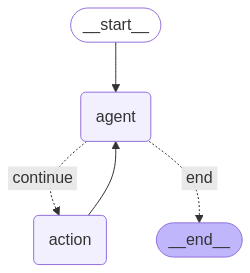

In [126]:
workflow: StateGraph = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, {"continue": "action", "end": END})
workflow.add_edge("action", "agent")

app: CompiledStateGraph = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [128]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Search the tool for what is the weather in Paris?")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Search the tool for what is the weather in Paris?
================================== Ai Message ==================================

The available tools lack the functionality to access real-time weather information.  Therefore, I cannot answer your question.
